In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import os
import sys

from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, squareform

from multiprocessing import Pool, cpu_count

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import pyarrow.parquet as pq

from matplotlib.backends.backend_pdf import PdfPages 

import gc
gc.collect()

0

In [3]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [4]:
sys.path.append('/groups/icecube/cyan/factory/DOMification')
from Enum.Flavour import Flavour
from Enum.EnergyRange import EnergyRange
from EventPeek.PseudoNormaliser import PseudoNormaliser

In [5]:
root_dir_noCR_CC_IN = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean_Contained/"

In [6]:
def get_interesting_events(truth_file:str, N_doms_cut = 1250):
    truth_df = pq.read_table(truth_file).to_pandas()
    N_doms = truth_df["N_doms"]
    
    interesting_event_no = truth_df[["event_no", "shard_no", "energy"]][N_doms > N_doms_cut]
    return interesting_event_no

In [7]:
def get_normalised_dom_features(pmt_event_df: pd.DataFrame, Q_cut: float = -1) -> pd.DataFrame:
    selected_columns = ["dom_x", "dom_y", "dom_z", "Qtotal", "t1"]
    event_np = pmt_event_df[selected_columns].to_numpy()
    normaliser = PseudoNormaliser()
    
    normalised_np = normaliser(event_np, column_names=selected_columns)
    normalised_df = pd.DataFrame(normalised_np, columns=selected_columns)
    normalised_df[["dom_x", "dom_y", "dom_z"]] = pmt_event_df[["dom_x", "dom_y", "dom_z"]].to_numpy()
    normalised_df = normalised_df[normalised_df["Qtotal"] > Q_cut] if Q_cut is not None else normalised_df

    return normalised_df

In [8]:
def add_string_column_to_event_df(event_df: pd.DataFrame, ref_position_df: pd.DataFrame, tolerance=2.0):
    event_df = event_df.copy()
    event_df['string'] = np.nan

    x_diff = np.square(ref_position_df['dom_x'].values[:, None] - event_df['dom_x'].values)
    y_diff = np.square(ref_position_df['dom_y'].values[:, None] - event_df['dom_y'].values)
    
    distances = np.sqrt(x_diff + y_diff)
    min_indices = np.argmin(distances, axis=0)

    within_tolerance = np.min(distances, axis=0) <= tolerance
    event_df.loc[within_tolerance, 'string'] = ref_position_df.iloc[min_indices[within_tolerance]]['string'].values

    return event_df

In [9]:
def get_string_df(event_df: pd.DataFrame):
    string_df = event_df.groupby("string").agg({"dom_x": "mean", "dom_y": "mean", "Qtotal": "sum"})
    string_df.reset_index(inplace=True)
    return string_df

In [10]:
# Optimised function: Reduce dtype and ensure stability
def calculate_horizontal_boundary(pmt_event_df: pd.DataFrame):
    xy_points = pmt_event_df[['dom_x', 'dom_y']].drop_duplicates().values.astype(np.float32, copy=False)
    if xy_points.shape[0] < 3:
        return xy_points  # Return raw points if not enough for ConvexHull
    
    try:
        hull = ConvexHull(xy_points)
        return xy_points[hull.vertices]
    except Exception:
        # print("ConvexHull failed: Points are nearly collinear.")
        return xy_points

In [11]:
def calculate_horizontal_PCA(boundary_points: np.ndarray):
    if boundary_points.shape[0] < 2:
        # print("⚠️ Warning: Not enough points for PCA. Returning NaNs.")
        return np.nan, np.nan, np.nan, np.nan  # ✅ Safe return to prevent crashing
    if np.all(boundary_points == boundary_points[0]):  # All points identical
        # print("⚠️ Warning: All points are identical. Returning NaNs.")
        return np.nan, np.nan, np.nan, np.nan
    centre = np.mean(boundary_points, axis=0)
    pca = PCA(n_components=2)
    try:
        pca.fit(boundary_points)
        eigenvalues = pca.explained_variance_
        eigenvectors = pca.components_
        major_axis_length, minor_axis_length = np.sqrt(eigenvalues)
        return major_axis_length, minor_axis_length, eigenvectors, centre
    except Exception as e:
        print(f"⚠️ PCA failed: {e}. Returning NaNs.")
        return np.nan, np.nan, np.nan, np.nan  # ✅ Return safe values

In [12]:
def compute_max_extent(boundary_points):
    dist_matrix = squareform(pdist(boundary_points))  # Compute all pairwise distances
    i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)  # Find indices of max distance
    point1, point2 = boundary_points[i], boundary_points[j]
    
    return point1, point2, dist_matrix[i, j]

In [13]:
def get_cos_power_extent_PCA_major(extent_end1: np.ndarray, 
                                    extent_end2: np.ndarray, 
                                    extent_max: float,
                                    eigen_vectors: np.ndarray,
                                    major_PCA: float, 
                                    power:int) -> float:
    if major_PCA == 0 or extent_max == 0:
        return np.nan
    extent_vector = extent_end2 - extent_end1
    extent_unit_vector = extent_vector / np.linalg.norm(extent_vector)
    pca_major_vector = eigen_vectors[0]
    cos_theta_squared = np.clip(np.dot(extent_unit_vector, pca_major_vector) ** power, 0, 1)
    return cos_theta_squared

In [14]:
def calculate_vertical_stretch(pmt_event_df: pd.DataFrame):
    stretch_per_string = pmt_event_df.groupby("string")["dom_z"].agg(lambda x: x.max() - x.min())
    if stretch_per_string.empty:
        return np.nan, np.nan, [np.nan, np.nan], np.nan
    stretch_mean = stretch_per_string.mean()
    stretch_max = stretch_per_string.max()
    top_one_sigma = stretch_per_string.quantile(0.843)
    bottom_one_sigma = stretch_per_string.quantile(0.157)
    half_interquartile_range = (top_one_sigma - bottom_one_sigma) / 2
    if stretch_per_string.empty or np.isnan(stretch_mean) or np.isnan(stretch_max):
        return np.nan, np.nan, [np.nan, np.nan], np.nan
    if stretch_per_string.isna().all():
        return np.nan, np.nan, [np.nan, np.nan], np.nan
    try:
        max_string = stretch_per_string.idxmax()
        max_z_positions = pmt_event_df.loc[pmt_event_df["string"] == max_string, "dom_z"].agg(["min", "max"]).values
    except Exception:
        max_string, max_z_positions = np.nan, [np.nan, np.nan]
    return stretch_mean, stretch_max, max_z_positions, half_interquartile_range

In [15]:
def get_composite_cosine_scores(extent_end1: np.ndarray, 
                               extent_end2: np.ndarray, 
                               extent_max: float,
                               eigen_vectors: np.ndarray,
                               major_PCA: float,
                               minor_PCA: float, 
                               power: int = 4) -> float:
    if major_PCA == 0 or extent_max == 0 or minor_PCA == 0:
        return np.nan
    extent_vector = extent_end2 - extent_end1
    extent_unit_vector = extent_vector / np.linalg.norm(extent_vector)
    pca_major_vector = eigen_vectors[0]
    pca_minor_vector = eigen_vectors[1]
    
    cosine_major = np.clip(np.dot(extent_unit_vector, pca_major_vector), -1, 1)
    cosine_minor = np.clip(np.dot(extent_unit_vector, pca_minor_vector), -1, 1)
    
    cosine_major_power = np.power(np.abs(cosine_major), power)
    cosine_minor_power = np.power(np.abs(cosine_minor), power)
    
    abs_diff = np.abs(cosine_major_power - cosine_minor_power)

    gaussian_combined = np.exp(-cosine_major_power - cosine_minor_power)

    # Quadratic sum for isotropy detection
    quadratic_diff_sum = (cosine_major_power - 0.5) ** 2 + (cosine_minor_power - 0.5) ** 2

    return abs_diff, gaussian_combined, quadratic_diff_sum


In [16]:
def get_rookies(pmt_event_df: pd.DataFrame, ref_position_df: pd.DataFrame, Q_cut = 0):
    pmt_event_df = add_string_column_to_event_df(pmt_event_df, ref_position_df)
    pseudo_normalised_df = get_normalised_dom_features(pmt_event_df, Q_cut)
    pseudo_normalised_df = add_string_column_to_event_df(pseudo_normalised_df, ref_position_df)
    string_df = get_string_df(pseudo_normalised_df)  # string, dom_x, dom_y, Qtotal
    border_xy = calculate_horizontal_boundary(pseudo_normalised_df)
    if border_xy.shape[0] < 3:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    major_PCA, minor_PCA, eigenvectors, centre_PCA = calculate_horizontal_PCA(border_xy)
    eccentricity_PCA = np.sqrt(1 - (minor_PCA / major_PCA)**2)
    aspect_contrast_PCA = (major_PCA - minor_PCA) / (major_PCA + minor_PCA)
    xy_end1, xy_end2, extent_max = compute_max_extent(border_xy)
    cos_squared_extent_PCA_major = get_cos_power_extent_PCA_major(xy_end1, xy_end2, extent_max, eigenvectors, major_PCA, 4)
    abs_diff, gaussian_combined, quadratic_diff_sum = get_composite_cosine_scores(xy_end1, xy_end2, extent_max, eigenvectors, major_PCA, minor_PCA)
    stretch_mean, stretch_max, max_z_positions, stretch_hiqr = calculate_vertical_stretch(pseudo_normalised_df)
    hypotenuse = np.sqrt(extent_max**2 + stretch_max**2)
    metrics = (hypotenuse, major_PCA, minor_PCA, eccentricity_PCA, aspect_contrast_PCA, cos_squared_extent_PCA_major, abs_diff, gaussian_combined, quadratic_diff_sum)
    return metrics

In [17]:
def plot_distribution(data_dict, title, xlabel, ylabel, binwidth, isLog=False, isDicLeft=False):
    fig, ax = plt.subplots(figsize=(13, 9))
    sample_data = np.array(next(iter(data_dict.values()), []))  # Convert to array
    if sample_data.size == 0 or np.all(np.isnan(sample_data.astype(float))):
        return None, None
    try:
        Nbins, binwidth, bins, counts, bin_centers = getHistoParam(
            sample_data, binwidth=binwidth, isLog=isLog, isDensity=False
        )
    except ValueError as e:
        return None, None
    for flavour, data in data_dict.items():
        clean_data = np.array(data, dtype=float)  # 🚀 **Ensure valid NumPy array**
        clean_data = clean_data[~np.isnan(clean_data)]  # Remove NaNs for histogram plotting
        colour_index = {Flavour.E: 2, Flavour.MU: 0, Flavour.TAU: 1}.get(flavour, 3)
        hatch_index = {Flavour.E: '/', Flavour.MU: '\\', Flavour.TAU: '-'}
        ax.hist(clean_data, bins=bins, color=getColour(colour_index), 
                histtype='step', label=fr"${{{flavour.latex}}}$", linewidth=3, hatch=hatch_index.get(flavour, None))
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    stats_summary = {f"N events": sum(len(d) for d in data_dict.values()),
                     "binwidth": f"{binwidth:.1f}",
                     "Nbins": Nbins}
    text_x_pos = 0.02 if isDicLeft else 0.80
    for flavour, data in data_dict.items():
        clean_data = np.array(data, dtype=float)  # Ensure valid NumPy array
        nan_count = np.isnan(clean_data).sum()  # Count NaN values
        valid_data = clean_data[~np.isnan(clean_data)]  # Remove NaNs for calculations

        flavour_stats = {
            f"${{{flavour.latex}}}$": '',
            "N_events": len(data),
            "N_NaN": nan_count,  # Add NaN count
            "max": f"{np.nanmax(valid_data):.2f}" if valid_data.size > 0 else "N/A",
            "min": f"{np.nanmin(valid_data):.2f}" if valid_data.size > 0 else "N/A",
            "mean": f"{np.nanmean(valid_data):.2f}" if valid_data.size > 0 else "N/A",
            "median": f"{np.nanmedian(valid_data):.2f}" if valid_data.size > 0 else "N/A",
            "std": f"{np.nanstd(valid_data):.2f}" if valid_data.size > 0 else "N/A",
        }
        colour_offset = {Flavour.E: 0.85, Flavour.MU: 0.65, Flavour.TAU: 0.45}
        text_position = colour_offset.get(flavour, 0.85)
        add_text_to_ax(text_x_pos, text_position, nice_string_output(flavour_stats), 
                       ax, fontsize=10, color='black')
    add_text_to_ax(0.70, 0.97, nice_string_output(stats_summary), ax, fontsize=10, color='black')
    # return fig, ax

In [18]:
def process_event(event_df_ref_Qcut):
    ref_position_file = "/groups/icecube/cyan/factory/DOMification/dom_ref_pos/unique_string_dom_completed.csv"
    ref_position_df = pd.read_csv(ref_position_file)
    event_df, ref_position_df, Q_cut = event_df_ref_Qcut
    return get_rookies(event_df, ref_position_df, Q_cut)

In [27]:
def collect_event_metrics(root_before_subdir: str, er: EnergyRange, part: int, Q_cut: int, num_shards_dict: dict):
    metrics = {key: {Flavour.E: [], Flavour.MU: [], Flavour.TAU: []} for key in [
        "hypotenuse", "major_PCA", "minor_PCA", "eccentricity_PCA", "aspect_contrast_PCA",
        "cos_power_extent_PCA_major", "abs_diff", "gaussian_combined", "quadratic_diff_sum"
    ]}

    ref_position_file = "/groups/icecube/cyan/factory/DOMification/dom_ref_pos/unique_string_dom_completed.csv"
    ref_position_df = pd.read_csv(ref_position_file)

    total_shards_processed = 0  # Count processed shards
    total_events_processed = 0  # Count processed events

    for flavour in [Flavour.E, Flavour.MU, Flavour.TAU]:
        subdir = os.path.join(root_before_subdir, EnergyRange.get_subdir(er, flavour))
        num_shards = num_shards_dict.get(flavour, 10)

        for shard_no in range(1, num_shards + 1):
            pmt_file = os.path.join(subdir, str(part), f"PMTfied_{shard_no}.parquet")
            if not os.path.exists(pmt_file):
                continue

            total_shards_processed += 1
            pmt_event_df = pq.read_table(pmt_file).to_pandas()
            if pmt_event_df.empty:
                continue
            pmt_event_df = pmt_event_df[:1000]
            total_events_processed += len(pmt_event_df)
            event_metrics = get_rookies(pmt_event_df, ref_position_df, Q_cut)
            
            # Store collected metrics
            metric_keys = list(metrics.keys())  
            for i, key in enumerate(metric_keys):
                metrics[key][flavour].append(event_metrics[i])

    return metrics


In [28]:
def plot_all_metrics(metrics):
    plot_params = [
        {"key": "hypotenuse", "title": "Hypotenuse Distribution (XYZ)", "xlabel": "Hypotenuse (XYZ) [m]", "ylabel": "Counts", "binwidth": 50},
        {"key": "major_PCA", "title": "Major PCA Distribution (XY)", "xlabel": "Major PCA (XY) [m]", "ylabel": "Counts", "binwidth": 25},
        {"key": "minor_PCA", "title": "Minor PCA Distribution (XY)", "xlabel": "Minor PCA (XY) [m]", "ylabel": "Counts", "binwidth": 25},
        {"key": "eccentricity_PCA", "title": "Eccentricity PCA (XY)", "xlabel": "Eccentricity", "ylabel": "Counts", "binwidth": 0.05, "isLog": False, "isDicLeft": True},
        {"key": "aspect_contrast_PCA", "title": "Aspect Contrast PCA (XY)", "xlabel": "Aspect Contrast", "ylabel": "Counts", "binwidth": 0.05},
        {"key": "cos_power_extent_PCA_major", "title": "Cos^4(θ) PCA (XY)", "xlabel": "Cos^4(θ)", "ylabel": "Counts", "binwidth": 0.05},
        {"key": "abs_diff", "title": "Absolute Difference PCA (XY)", "xlabel": "Abs Difference", "ylabel": "Counts", "binwidth": 0.05},
        {"key": "gaussian_combined", "title": "Gaussian Combined PCA (XY)", "xlabel": "Gaussian Combined", "ylabel": "Counts", "binwidth": 0.05},
        {"key": "quadratic_diff_sum", "title": "Quadratic Difference Sum PCA (XY)", "xlabel": "Quadratic Difference Sum", "ylabel": "Counts", "binwidth": 0.05},
    ]

    for param in plot_params:
        key = param["key"]
        
        # 🚀 **Check for empty data**
        data_available = any(len(metrics[key][f]) > 0 for f in [Flavour.E, Flavour.MU, Flavour.TAU])
        if not data_available:
            continue  # Skip empty plots
        
        # Call plot_distribution with explicitly named arguments
        plot_distribution(
            data_dict=metrics[key],
            title=param["title"],
            xlabel=param["xlabel"],
            ylabel=param["ylabel"],
            binwidth=param["binwidth"],
            isLog=param.get("isLog", False),  # Default to False if not specified
            isDicLeft=param.get("isDicLeft", False)  # Default to False if not specified
        )


In [29]:
def run_for_your_life(root_before_subdir, er, part, Q_cut, num_shards_dict):
    metrics = collect_event_metrics(root_before_subdir, er, part, Q_cut, num_shards_dict)

    plot_all_metrics(metrics)

    # return metrics

In [30]:
num_shards_dict = {
        Flavour.E: 1,   # num shards for nu e(4)
        Flavour.MU: 2,  # num shards for nu mu(9)
        Flavour.TAU: 1   # num shards for nu tau(4)
    }

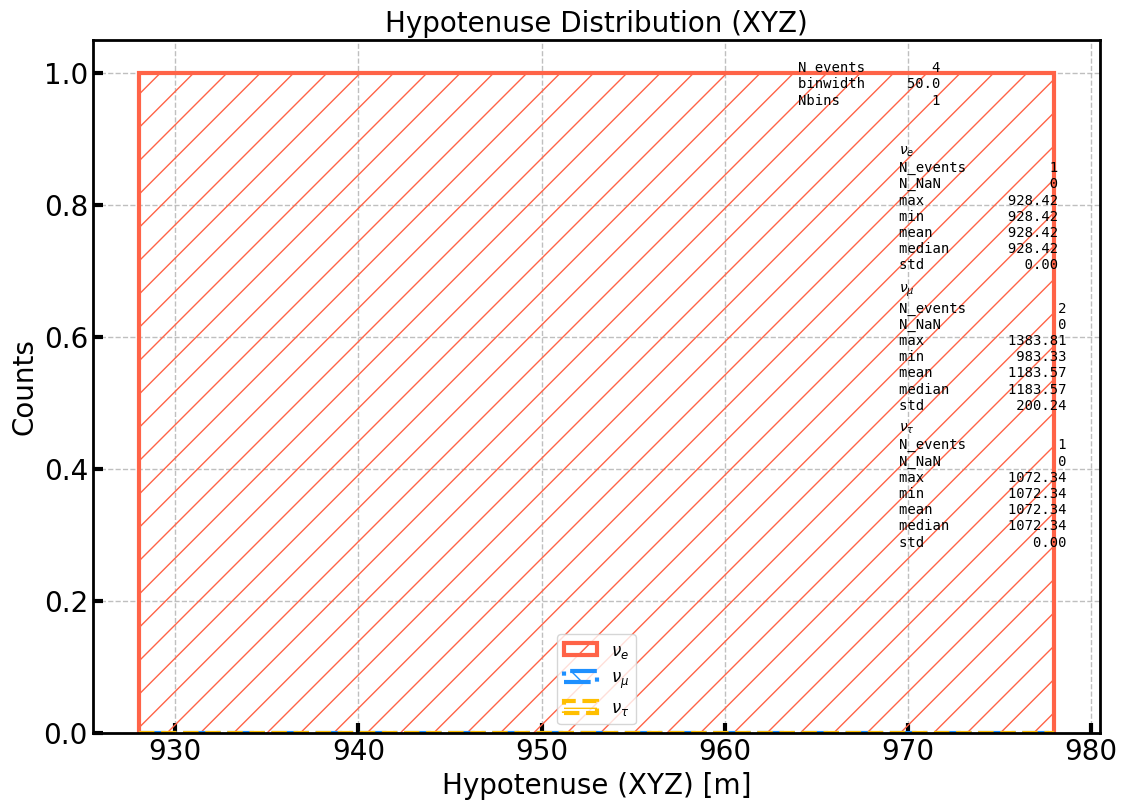

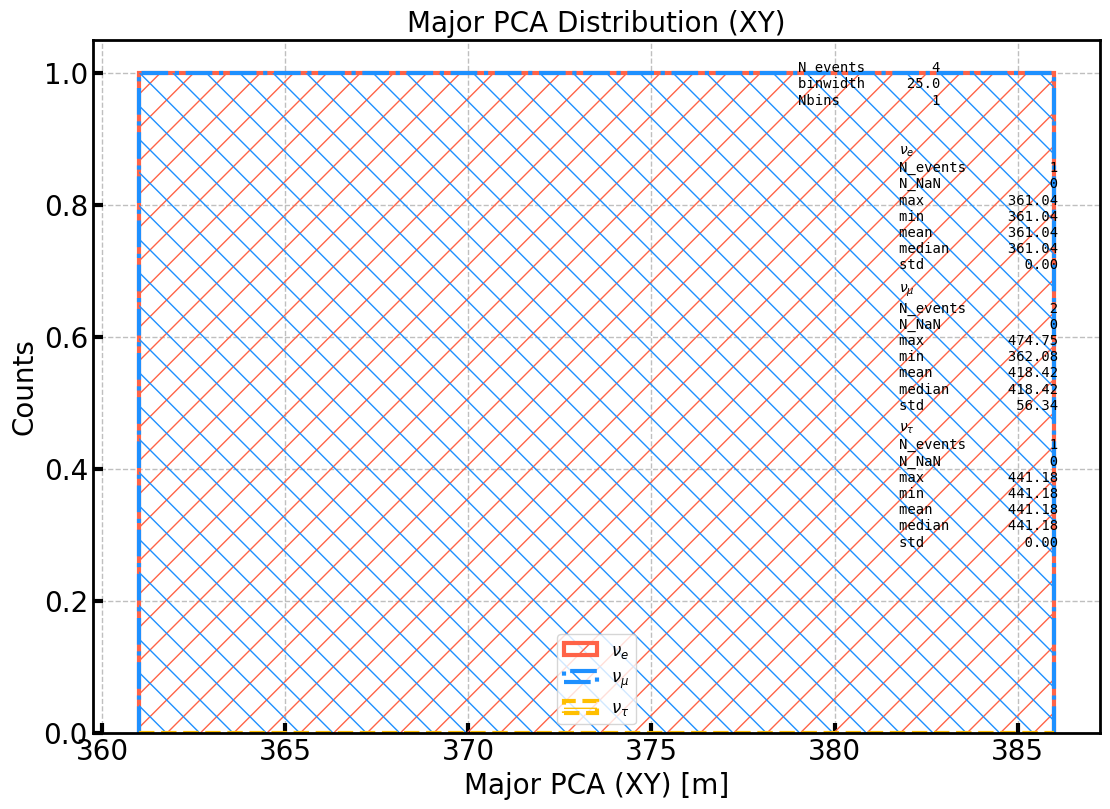

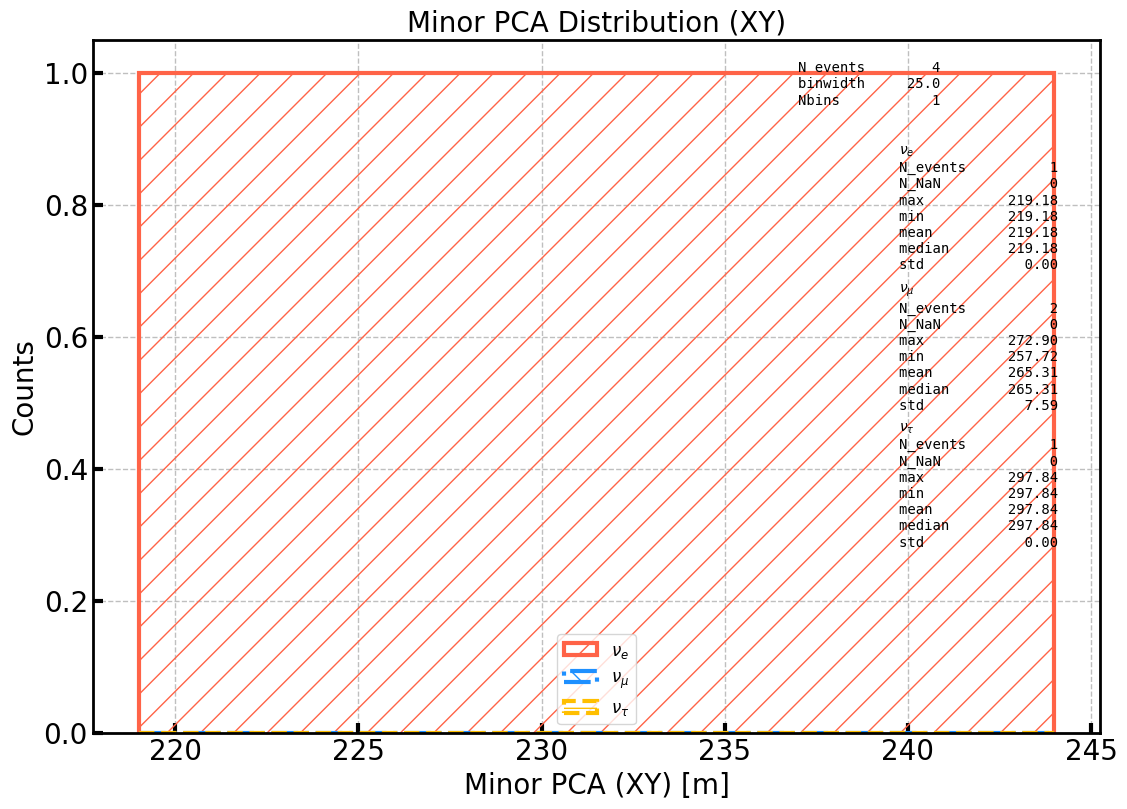

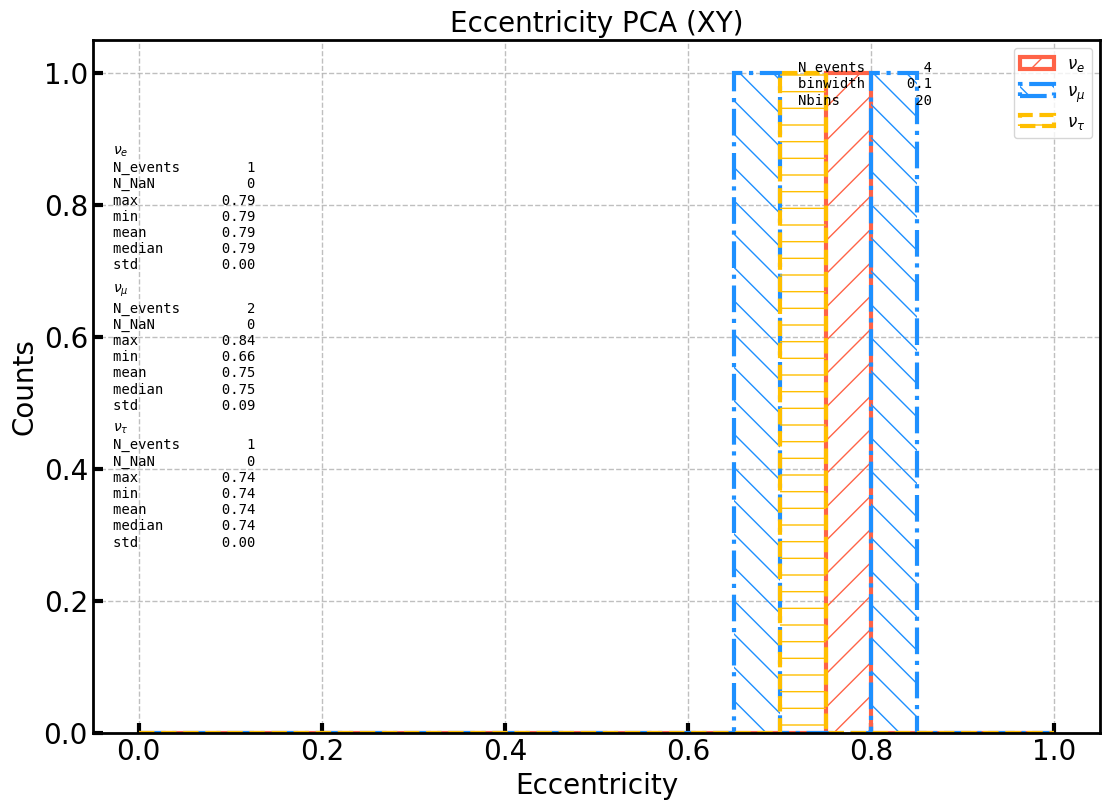

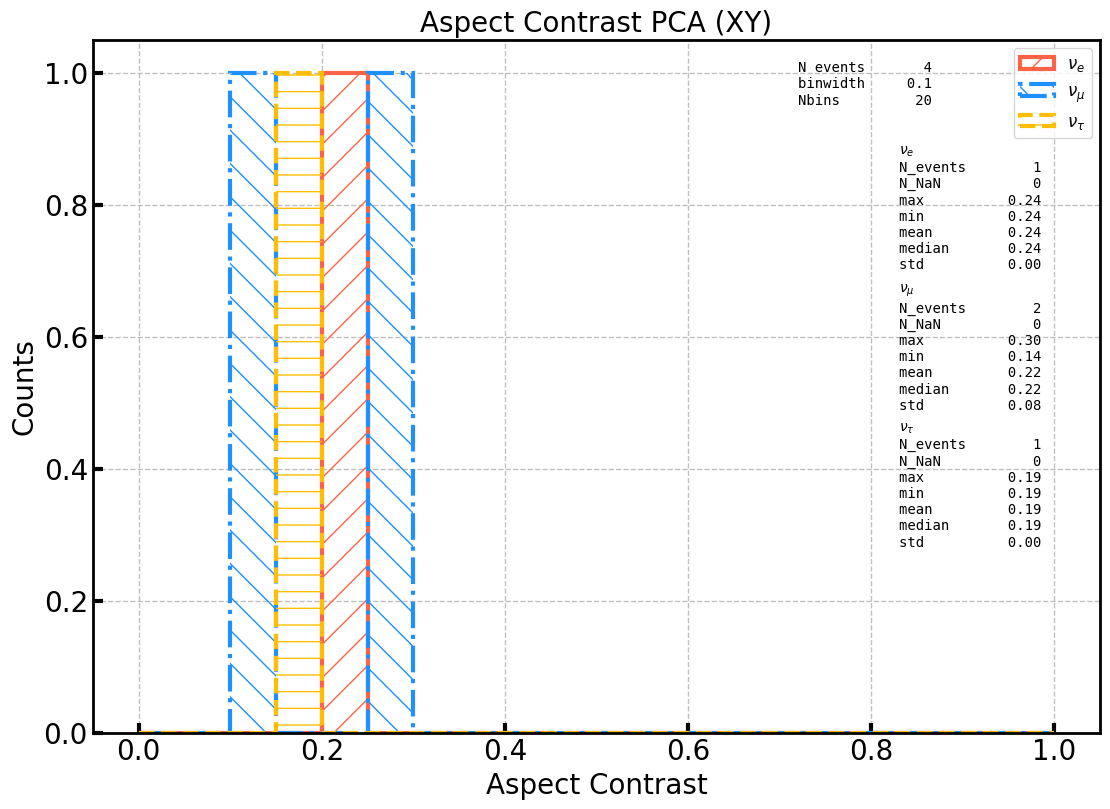

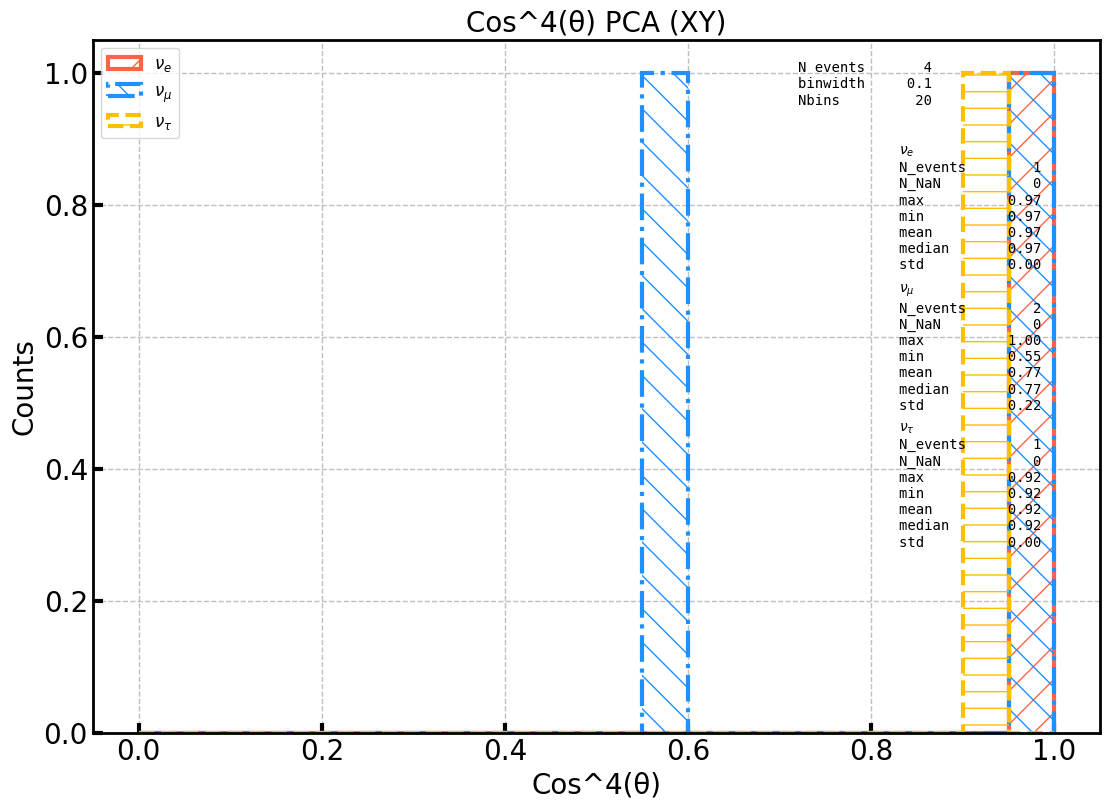

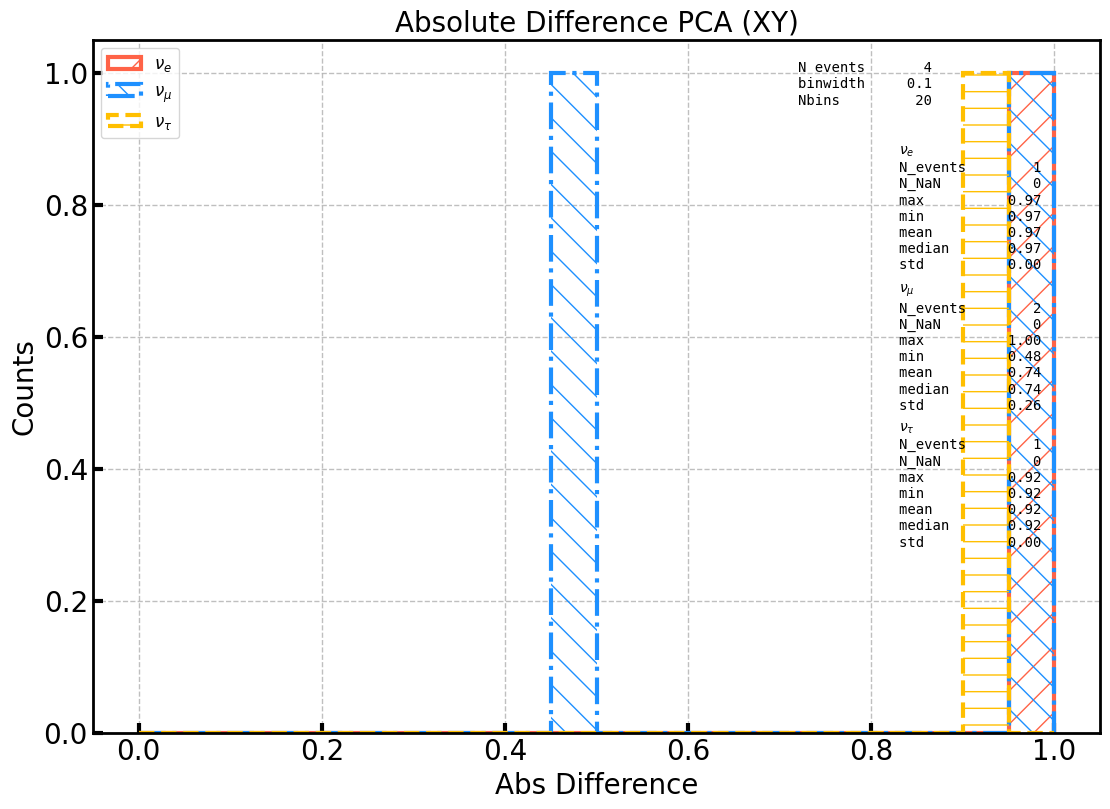

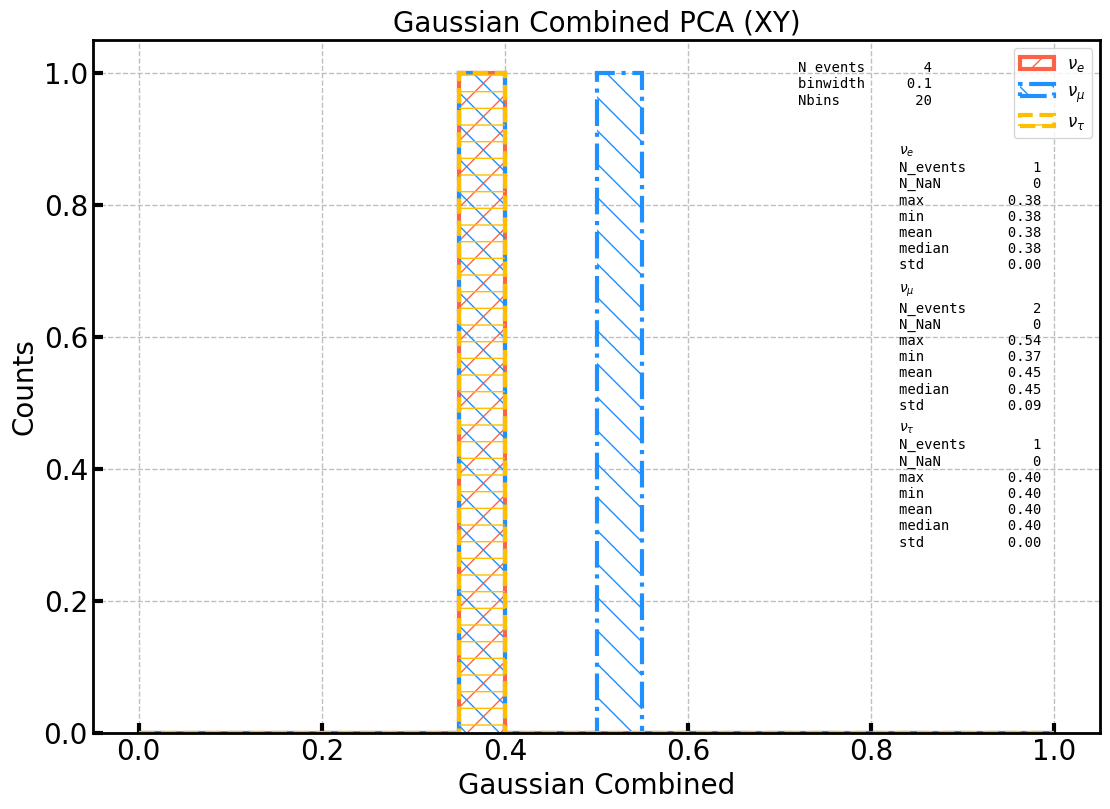

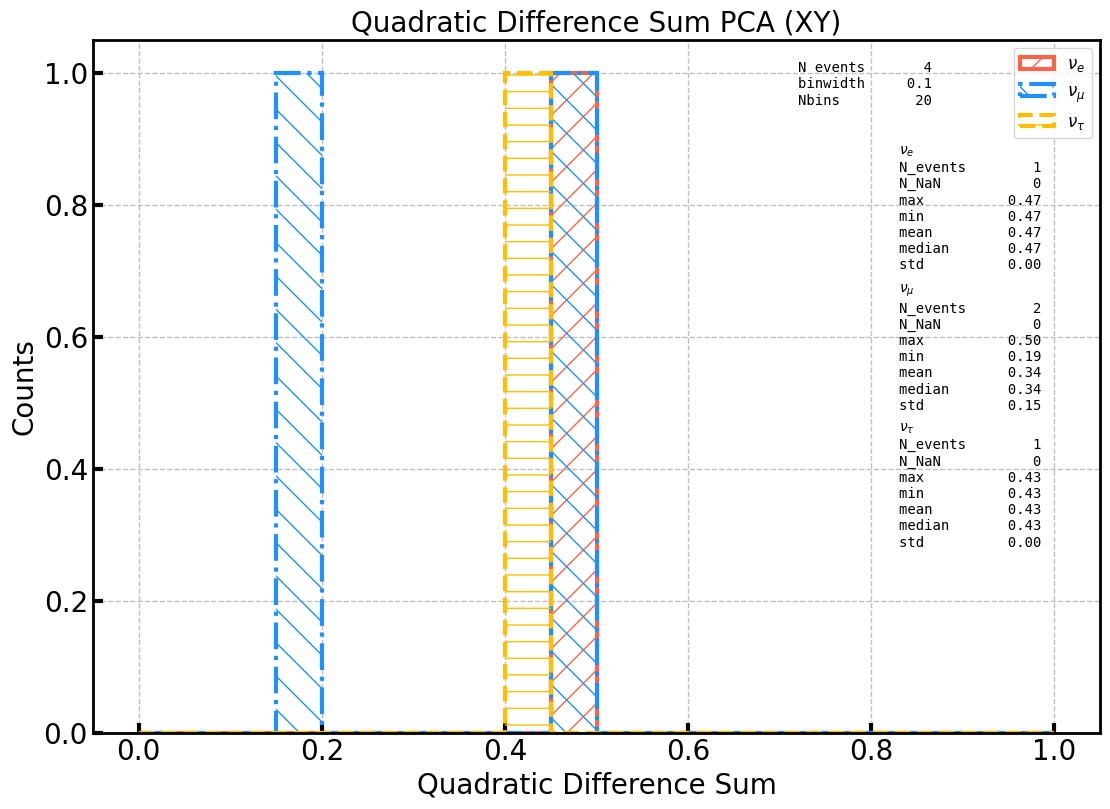

In [31]:
run_for_your_life(root_before_subdir = root_dir_noCR_CC_IN, 
                    er = EnergyRange.ER_10_TEV_1_PEV,
                    part = 1, 
                    Q_cut=-1,
                    num_shards_dict=num_shards_dict)
# 